# Network Analysis
### The next section contains the network analysis of the Stack Overflow data. 
The network will be modeled as a directed, weighted graph, in which each node is a unique user on Stack Overflow, and each edge is an interaction between a pair of users. The associated weight is the number of times these users have interacted.

#### The following steps are taken in this part of the Stack Overflow investigation:

1. Create individual networks for each programming language with authors as nodes and interactions (answering questions or commenting answers) as links.

2. Create one big Stack Overflow graph including all 16 programming languages with same types of nodes and links.

3. Perform basic network analysis (counts, degree distribution etc.) on language-specific networks and the Stack Overflow network. Comment on these results.

4. Vizualize the StackOverflow-network.

5. Perform advanced network analysis on the StackOverflow-network by investigating the different subnetworks, communities, modularity etc.

6. Use the Louvain algorithm to create a network from the data and compare to the StackOverflow-network.
 

In [1]:
### Imports
import os
import pandas as pd
import numpy as np
import networkx as nx
import netwulf as nf
import community as cm
from scipy import stats 
from operator import itemgetter 
from collections import Counter
import re
from glob import glob as glob  # glob
from tqdm import tqdm
from pelutils import Table, thousand_seps
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

loved_languages = {
    "rust":        86.1,
    "typescript":  67.1,
    "python":      66.7,
    "kotlin":      62.9,
    "go":          62.3,
    "dart":        62.1,
    "c#":          59.7,
    "javascript":  58.3,
    "haskell":     51.7,
    "java":        44.1,
    "c++":         43.4,
    "ruby":        42.9,
    "c":           33.1,
    "perl":        28.6,
    "objective-c": 23.4,
    "vba":         19.6,
}
language_colors = {
    "rust":        'peru',
    "typescript":  'blue',
    "python":      'orange',
    "kotlin":      'navy',
    "go":          'grey',
    "dart":        'cyan',
    "c#":          'purple',
    "javascript":  'yellow',
    "haskell":     'black',
    "java":        'green',
    "c++":         'red',
    "ruby":        'olive',
    "c":           'pink',
    "perl":        'magenta',
    "objective-c": 'lime',
    "vba":         'azure',
}

In [2]:
### Data is loaded
data = pd.read_pickle('/home/augustsemrau/drive/6semester/CSS_02467/css-project/data.pkl')
# data

In [33]:
### Data summary
so = data
t = Table()
t.add_row(["Language", "Questions", "Answers", "Comments", "Total"])
for lang in tqdm(loved_languages):
    t.add_row([
        lang.capitalize(),
        *[thousand_seps(sum((so["language"] == lang) & (so["type"] == t))) for t in ("q", "a", "c")],
        thousand_seps(sum(so["language"] == lang)),
    ], [1, 0, 0, 0, 0])
t.add_row([
    "",
    thousand_seps(sum(so["type"] == "q")),
    thousand_seps(sum(so["type"] == "a")),
    thousand_seps(sum(so["type"] == "c")),
    thousand_seps(len(so)),
], [1, 0, 0, 0, 0])
print("Number of items in dataset")
print(t)
del so

100%|██████████| 16/16 [00:10<00:00,  1.51it/s]
Number of items in dataset
Language    | Questions | Answers | Comments | Total    
Rust        |     6,583 |   7,971 |   25,146 |    39,700
Typescript  |    11,979 |  17,489 |   45,271 |    74,739
Python      |    13,124 |  18,173 |   52,070 |    83,367
Kotlin      |     8,075 |  12,466 |   29,415 |    49,956
Go          |    12,961 |  17,250 |   47,044 |    77,255
Dart        |     6,159 |   9,806 |   21,400 |    37,365
C#          |    13,003 |  16,587 |   60,028 |    89,618
Javascript  |    13,135 |  18,249 |   54,631 |    86,015
Haskell     |    10,948 |  15,170 |   50,559 |    76,677
Java        |    12,937 |  17,124 |   53,732 |    83,793
C++         |    13,029 |  17,676 |   81,591 |   112,296
Ruby        |    13,123 |  18,036 |   52,550 |    83,709
C           |    13,148 |  19,972 |   94,494 |   127,614
Perl        |     9,814 |  15,532 |   54,959 |    80,305
Objective-c |    11,829 |  14,709 |   48,737 |    75,275
Vba         |

## 1. Create individual networks for each programming language with authors as nodes and interactions (answering questions or commenting questions/answers) as links.

In [20]:
### Function for creating programming-language-specific networks
def lang_networks(data, prog_language):

    ## Get data corresponding to given programming language
    lang_data = data.loc[data['language'] == prog_language]

    ## Get Questions, answers and comments seperately
    lang_questions = lang_data.loc[lang_data['type'] == 'q']
    lang_answers = lang_data.loc[lang_data['type'] == 'a']
    lang_comments = lang_data.loc[lang_data['type'] == 'c']

    ## Get authors of questions and answers
    question_authors = dict(zip(lang_questions['question_id'], lang_questions['owner/user_id']))
    answer_authors = dict(zip(lang_answers['answer_id'], lang_answers['owner/user_id']))

    ## Find parent id's of all datapoints
    lang_data['parent_author'] = ""
    for index, row in tqdm(lang_data.iterrows()):

        ## If question, no parent author (no self-loops)
        if row['type'] == 'q':  
            row['parent_author'] = None

        ## If answer, parent author is author of question answered
        elif row['type'] == 'a':
            try:
                row['parent_author'] = question_authors[str(row['question_id'])]
            except: # Parent missing
                row['parent_author'] = None
        
        ## If comment, parent author is either author of commented question or answer
        else:
            try:  # Commenting on an answer
                row['parent_author'] = answer_authors[str(row['answer_id'])]
            except:
                try:  # Commenting on a question
                    row['parent_author'] = question_authors[str(row['question_id'])]
                except:  # Parent missing
                    row['parent_author'] = None

    ## Filter for NANs, there are a lot for comments..
    print(f'{prog_language} data before filtering for NANs', lang_data.shape)
    lang_data = lang_data[lang_data['parent_author'].notnull()]
    lang_data = lang_data[lang_data['owner/user_id'].notnull()]
    lang_data = lang_data[lang_data['parent_author'] != 'None']
    lang_data = lang_data[lang_data['owner/user_id'] != 'None']
    lang_data = lang_data[lang_data['owner/user_id'] != lang_data['parent_author']]
    print(f'{prog_language} data after filtering for NANs', lang_data.shape)

    ## Create weighted edge list
    edge_list = lang_data.groupby(['owner/user_id', 'parent_author']).size().to_frame('weight').reset_index()
    
    ## Define nodes and weights
    sources = list(edge_list['owner/user_id'])
    targets = list(edge_list['parent_author'])
    weights = list(edge_list['weight'])

    ## Create tuple list of edges with weights
    edges = [(sources[i], targets[i], weights[i]) for i in range(len(sources))]

    ## Create graph, add nodes and edges
    lang_graph = nx.DiGraph()
    lang_graph.add_nodes_from(sources)
    lang_graph.add_nodes_from(targets)
    lang_graph.add_weighted_edges_from(edges)

    return lang_graph


In [3]:
### This cell creates the graphs for each programming language and saves a pickle
for prog_lang in loved_languages.keys():
    print(prog_lang)
    prog_lang_graph = lang_networks(data=data, prog_language=prog_lang)
    ## Save to pickle for later use
    path = os.getcwd() + '/graphs/' + str(prog_lang) + '_graph.pkl'
    nx.write_gpickle(prog_lang_graph, path)

## 2. Create one big StackOverflow-network including all 16 programming languages with same types of nodes and links.

In [6]:
### Function for creating one big Stack-Overflow network graph
def so_network(so_data, directed=True):

    ## Get Questions, answers and comments seperately
    questions = so_data.loc[so_data['type'] == 'q']
    answers = so_data.loc[so_data['type'] == 'a']
    comments = so_data.loc[so_data['type'] == 'c']

    ## Get authors of questions and answers
    question_authors = dict(zip(questions['question_id'], questions['owner/user_id']))
    answer_authors = dict(zip(answers['answer_id'], answers['owner/user_id']))

    ## Find parent id's of all datapoints
    so_data['parent_author'] = ""
    for index, row in tqdm(so_data.iterrows()):

        ## If question, no parent author (no self-loops)
        if row['type'] == 'q':  
            row['parent_author'] = None

        ## If answer, parent author is author of question answered
        elif row['type'] == 'a':
            try:
                row['parent_author'] = question_authors[str(row['question_id'])]
            except: # Parent missing
                row['parent_author'] = None
        
        ## If comment, parent author is either author of commented question or answer
        else:
            try:  # Commenting on an answer
                row['parent_author'] = answer_authors[str(row['answer_id'])]
            except:
                try:  # Commenting on a question
                    row['parent_author'] = question_authors[str(row['question_id'])]
                except:  # Parent missing
                    row['parent_author'] = None

    ## Filter for NANs, there are a lot for comments..
    print('Stack Overflow data before filtering for NANs', so_data.shape)
    so_data = so_data[so_data['parent_author'].notnull()]
    so_data = so_data[so_data['owner/user_id'].notnull()]
    so_data = so_data[so_data['parent_author'] != 'None']
    so_data = so_data[so_data['owner/user_id'] != 'None']
    so_data = so_data[so_data['owner/user_id'] != so_data['parent_author']]
    print('Stack Overflow data after filtering for NANs', so_data.shape)

    ## Create weighted edge list for all sets of source, target and programming language
    edge_list = so_data.groupby(['owner/user_id', 'parent_author', 'language']).size().to_frame('weight').reset_index()

    ## Make language and weight info-dict
    edge_list['language_weight'] = edge_list.apply(lambda row: {row['language']:row['weight']}, axis=1)

    print('Edge list before accomodating for bilingual source-target pairs', edge_list.shape)

    ## Find duplicates, ie. source-target pairs interacting on 2 or more different prog. languages
    bilinguals = edge_list[edge_list.duplicated(['owner/user_id', 'parent_author'], keep=False)]
    bilinguals_last = bilinguals[bilinguals.duplicated(['owner/user_id', 'parent_author'], keep='first')]

    ## Drop duplicates keeping first instance
    edge_list = edge_list.drop_duplicates(['owner/user_id', 'parent_author'], keep='first')

    ## Add the duplicates' language-weight data to the first instance of the interaction
    for _, row in tqdm(bilinguals_last.iterrows()):
        index = edge_list.index[(edge_list['owner/user_id'] == row['owner/user_id']) & (edge_list['parent_author'] == row['parent_author'])]
        edge_list.loc[index]['language_weight'].item()[row['language']] = row['weight']

    print('Edge list after accomodating for bilingual interaction pairs', edge_list.shape)
    
    # edge_list = edge_list[edge_list]

    ## Define nodes and weights
    sources = list(edge_list['owner/user_id'])
    targets = list(edge_list['parent_author'])
    weights = list(edge_list['weight'])
    language_weights = list(edge_list['language_weight'])
    
    ## Create graph, adding nodes and edges
    if directed:
        so_graph = nx.DiGraph()
    else:
        so_graph = nx.Graph()
        
    for i in tqdm(range(len(sources))):

        ## If node not already in graph, we add it, otherwise we add the language weights
        if sources[i] not in so_graph:
            so_graph.add_node(sources[i], languages=language_weights[i], top_language=None)
        else:
            prog_langs = list(language_weights[i].keys())
            prog_lang_weights = list(language_weights[i].values())
            for j in range(len(prog_langs)):
                if str(prog_langs[j]) not in so_graph.nodes[sources[i]]['languages']:
                    so_graph.nodes[sources[i]]['languages'][str(prog_langs[j])] = int(prog_lang_weights[j])
                else:
                    so_graph.nodes[sources[i]]['languages'][str(prog_langs[j])] += int(prog_lang_weights[j])
        
        if targets[i] not in so_graph:
            so_graph.add_node(targets[i], languages=language_weights[i], top_language=None)
        else:
            prog_langs = list(language_weights[i].keys())
            prog_lang_weights = list(language_weights[i].values())
            for j in range(len(prog_langs)):
                if str(prog_langs[j]) not in so_graph.nodes[targets[i]]['languages']:
                    so_graph.nodes[targets[i]]['languages'][str(prog_langs[j])] = int(prog_lang_weights[j])
                else:
                    so_graph.nodes[targets[i]]['languages'][str(prog_langs[j])] += int(prog_lang_weights[j])

        so_graph.add_edge(sources[i], targets[i])#, weight=sum(language_weights[i].values()))

    ## Add  top language as node attribute
    for i in so_graph:
        top_lang = sorted(so_graph.nodes[i]['languages'], key=so_graph.nodes[i]['languages'].get)[-1]
        so_graph.nodes[i]['top_language'] = top_lang
        so_graph.nodes[i]['color'] = language_colors[so_graph.nodes[i]['top_language']]

    return so_graph

In [7]:
### This cell creates the Stack Overflow graph and saves a pickle
# so_graph = so_network(so_data=data, directed=True)
# ## Save to pickle for later use
# path = os.getcwd() + '/graphs/' + 'so_graph.pkl'
# nx.write_gpickle(so_graph, path)

so_undirected_graph = so_network(so_data=data, directed=False)
## Save to pickle for later use
path = os.getcwd() + '/graphs/' + 'so_undirected_graph.pkl'
nx.write_gpickle(so_undirected_graph, path)

1269887it [01:34, 13378.59it/s]
Stack Overflow data before filtering for NANs (1269887, 14)
Stack Overflow data after filtering for NANs (442372, 14)
Edge list before accomodating for bilingual source-target pairs (355329, 5)
3539it [03:26, 17.13it/s]
100%|██████████| 351790/351790 [00:02<00:00, 158362.63it/s]


## 3. Perform basic network analysis (counts, degree distribution etc.) on language-specific networks and the Stack Overflow network. Comment on these results.

In [6]:
### This cell loads all the pickled graphs
graphs = {prog_lang : None for prog_lang in loved_languages.keys()}

## First the single programming language graphs
for prog_lang in tqdm(graphs.keys()):
    # print(prog_lang)
    prog_lang_graph_path = os.getcwd() + '/graphs/' + str(prog_lang) + '_graph.pkl'
    graphs[prog_lang] = nx.read_gpickle(prog_lang_graph_path)

## Then the Stack Overflow graph
so_graph_path = os.getcwd() + '/graphs/' + 'so_graph.pkl'
so_graph = nx.read_gpickle(so_graph_path)
# print('stack_overflow')
graphs['stack_overflow'] = so_graph

100%|██████████| 16/16 [00:00<00:00, 22.44it/s]


In [7]:
### This cell contains function for retrieving basic analysis metrics

## Number of nodes, number of links and density of graph
def basic_graph_analysis(graph):
    num_nodes = graph.number_of_nodes()
    num_links = graph.number_of_edges()
    density = nx.classes.function.density(graph)
    return num_nodes, num_links, round(density, 7)

## In and Out-degrees
def graph_degrees(graph):
    in_degrees = list(dict(graph.in_degree()).values())
    out_degrees = list(dict(graph.out_degree()).values())
    return in_degrees, out_degrees

In [8]:
### Graphs basic summary
t = Table()
t.add_row(["Language", "Num Nodes", "Num Links", "Density"])
for prog_lang in graphs.keys():
    num_nodes, num_links, density = basic_graph_analysis(graph=graphs[str(prog_lang)])
    t.add_row([prog_lang.capitalize(), num_nodes, num_links, density], [1, 0, 0, 0])

print("Basic statistics of programming language graphs")
print(t)

Basic statistics of programming language graphs
Language       | Num Nodes | Num Links | Density  
Rust           |      5288 |     12665 |  0.000453
Typescript     |     18536 |     27049 |  7.87e-05
Python         |     21000 |     30229 |  6.85e-05
Kotlin         |     11176 |     18041 | 0.0001445
Go             |     13625 |     26398 | 0.0001422
Dart           |      7644 |     13137 | 0.0002249
C#             |     20359 |     31322 |  7.56e-05
Javascript     |     23252 |     30983 |  5.73e-05
Haskell        |      7224 |     24351 | 0.0004667
Java           |     21732 |     29568 |  6.26e-05
C++            |     18545 |     38951 | 0.0001133
Ruby           |     14867 |     28776 | 0.0001302
C              |     19631 |     44832 | 0.0001163
Perl           |      9569 |     24870 | 0.0002716
Objective-c    |     14199 |     24775 | 0.0001229
Vba            |     14348 |     29194 | 0.0001418
Stack_overflow |    198337 |    351790 |   8.9e-06


In [9]:
### Degree summary
t = Table()
t.add_row(["Language", "Avg in.", "Avg out.", "Median in.", "Median out.", "Max in.", "Max out.", "Min in.", "Min out.", "Mode in.(#)", "Mode out.(#)"])

for prog_lang in graphs.keys():

    # Get degrees
    in_degrees, out_degrees = graph_degrees(graph=graphs[str(prog_lang)])

    # Calculate in-statistics
    avg_in = round(np.mean(in_degrees), 6)
    median_in = np.median(in_degrees)
    max_in = max(in_degrees)
    min_in = min(in_degrees)
    mode_in = stats.mode(in_degrees)

    # Calculate out-statistics
    avg_out = round(np.mean(out_degrees), 6)
    median_out = np.median(out_degrees)
    max_out = max(out_degrees)
    min_out = min(out_degrees)
    mode_out = stats.mode(out_degrees)

    # Add to table
    t.add_row([prog_lang.capitalize(), avg_in, avg_out, median_in, median_out, max_in, max_out, min_in, min_out, f'{int(mode_in[0])} ({int(mode_in[1])})', f'{int(mode_out[0])} ({int(mode_out[1])})'], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

print("Basic degree (in. and out.) analysis for programming language graphs")
print(t)

Basic degree (in. and out.) analysis for programming language graphs
Language       | Avg in.  | Avg out. | Median in. | Median out. | Max in. | Max out. | Min in. | Min out. | Mode in.(#) | Mode out.(#)
Rust           | 2.395045 | 2.395045 |        1.0 |         1.0 |     475 |     1457 |       0 |        0 |    0 (1434) |     1 (2786)
Typescript     | 1.459268 | 1.459268 |        1.0 |         1.0 |     305 |      399 |       0 |        0 |    0 (7730) |    1 (11420)
Python         | 1.439476 | 1.439476 |        1.0 |         1.0 |      58 |      249 |       0 |        0 |    0 (7620) |    1 (12394)
Kotlin         | 1.614263 | 1.614263 |        1.0 |         1.0 |      94 |      181 |       0 |        0 |    0 (4640) |     1 (6738)
Go             | 1.937468 | 1.937468 |        1.0 |         1.0 |     348 |      967 |       0 |        0 |    0 (4468) |     1 (7842)
Dart           | 1.718603 | 1.718603 |        1.0 |         1.0 |     360 |      676 |       0 |        0 |    0 (3498) |

<ipython-input-39-44e947636007>:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i,j].set_xlim([0, 2.5e3])
<ipython-input-39-44e947636007>:29: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i,j].set_ylim([1e-7, 0])
<ipython-input-39-44e947636007>:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i,j].set_xlim([0, 2.5e3])
<ipython-input-39-44e947636007>:29: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i,j].set_ylim([1e-7, 0])
<ipython-input-39-44e947636007>:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i,j].set_xlim([0, 2.5e3])
<ipython-input-39-44e947636007>:29: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ig

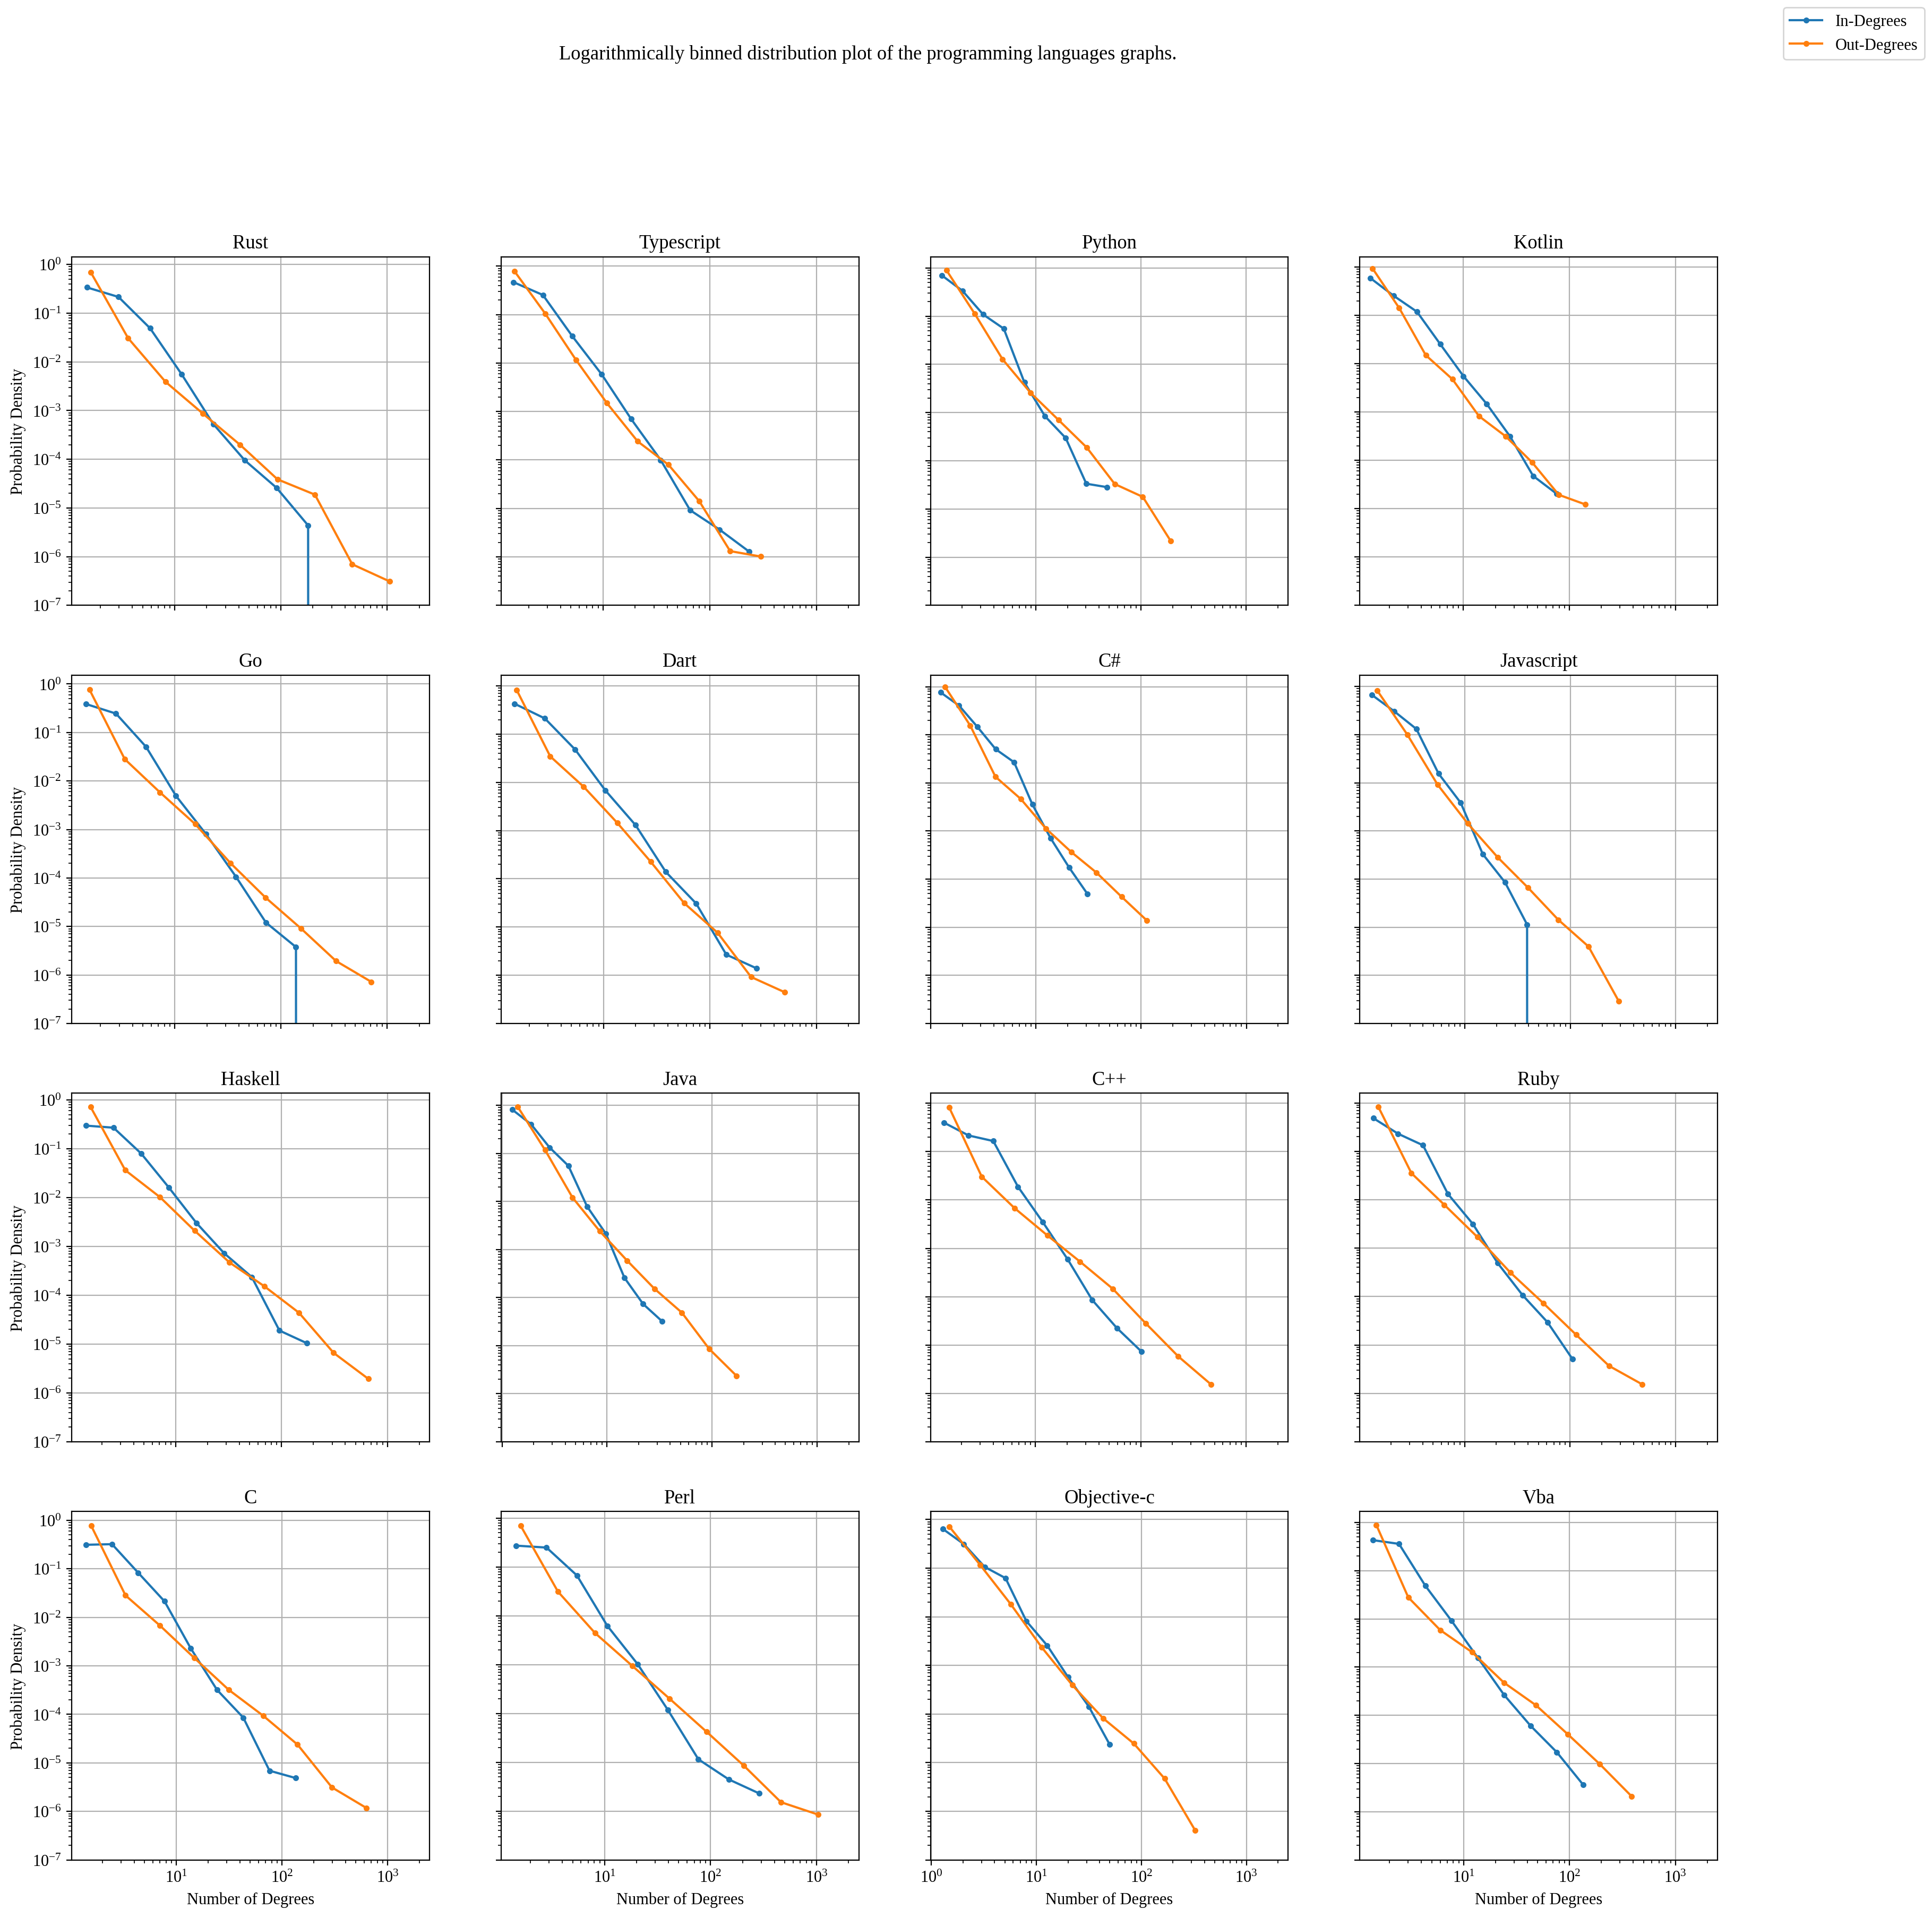

In [39]:
### This cell plots the in-out histograms for the single programming language networks

## Function for computing histograms
def in_out_degree_histogram(graph):

    in_degrees, out_degrees = graph_degrees(graph)
    bins = np.logspace(0, np.log10(max(in_degrees)), 10)
    in_hist, edges = np.histogram(in_degrees, bins=bins, density=True)
    x_in = (edges[1:] + edges[:-1]) / 2.

    bins = np.logspace(0, np.log10(max(out_degrees)), 10)
    out_hist, edges = np.histogram(out_degrees, bins=bins, density=True)
    x_out = (edges[1:] + edges[:-1]) / 2.
    
    return in_hist, x_in, out_hist, x_out

## Setup plot settings
def setup_mpl():
    mpl.rcParams['font.family'] = "Liberation Serif"
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['figure.figsize'] = (20,20)
    mpl.rcParams['figure.dpi'] = 200
    #mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

## Create plots
fig, axs = plt.subplots(4,4)
fig.suptitle('Logarithmically binned distribution plot of the programming languages graphs.')

for i in range(4):
    for j in range(4):
        prog_lang = list(graphs.keys())[i*4+j]
        # print(prog_lang)
        in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs[str(prog_lang)])
        
        axs[i,j].plot(x_in, in_hist, marker='.', label='In-Degrees')
        axs[i,j].plot(x_out, out_hist, marker='.', label='Out-Degrees')
        axs[i,j].set_xscale('log')
        axs[i,j].set_yscale('log')
        axs[i,j].set_xlim([0, 2.5e3])
        axs[i,j].set_ylim([1e-7, 0])
        axs[i,j].set_title(f"{prog_lang.capitalize()}")
        axs[i,j].grid()

## Get labels on legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[0:2], labels[0:2])

for ax in axs.flat:
    ax.set(xlabel='Number of Degrees', ylabel='Probability Density')
    ax.label_outer()

plt.show()



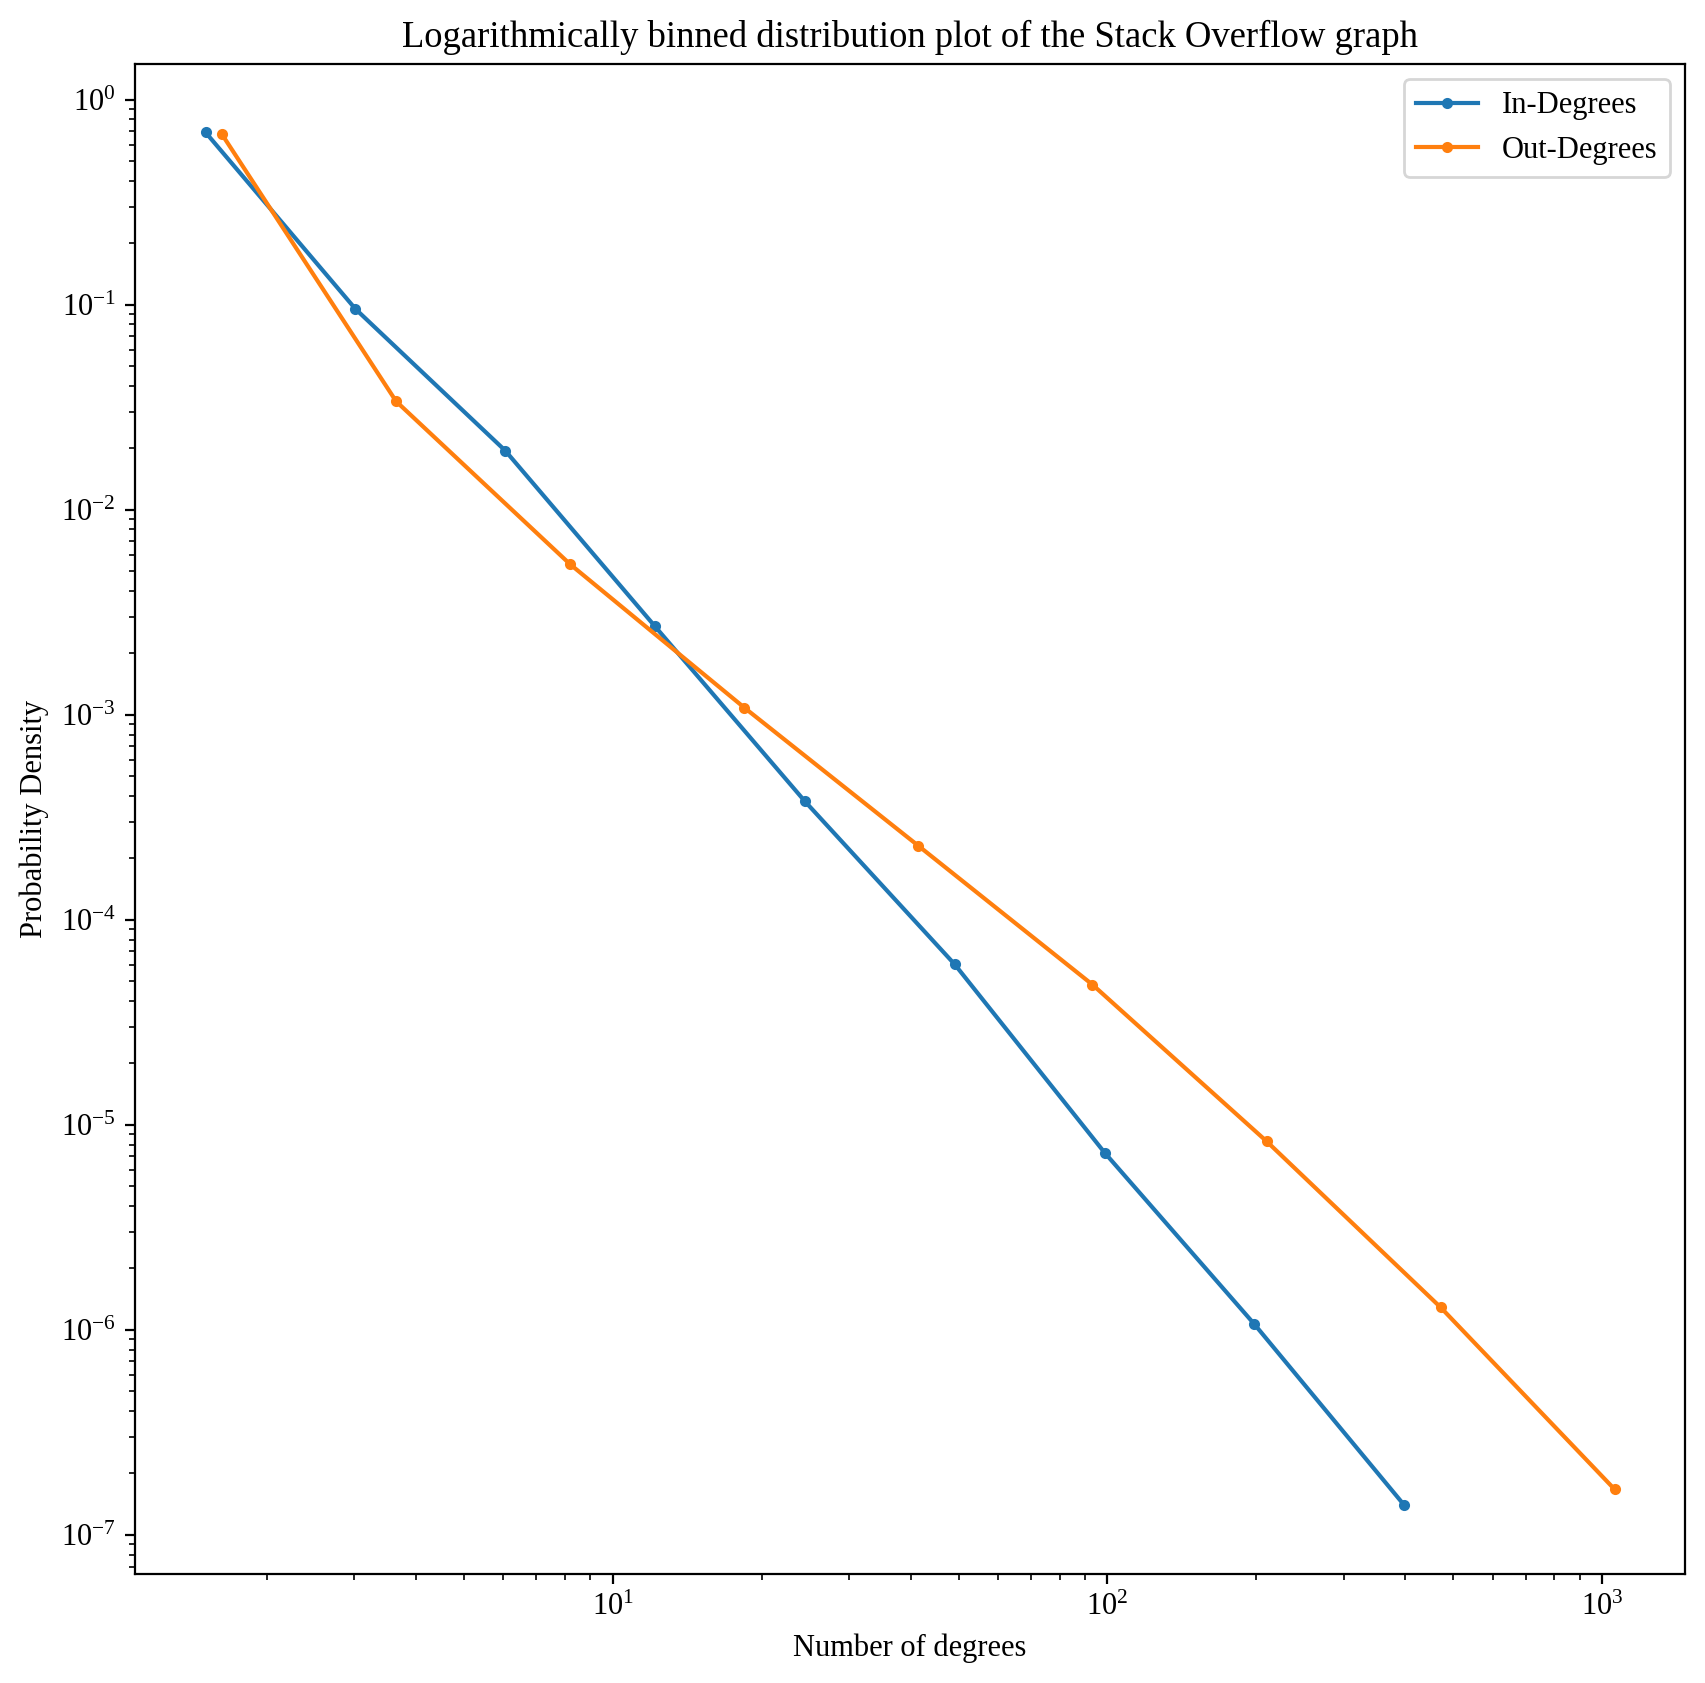

In [44]:
### This cell plots the in-out histogream for the big Stack Overflow network

## Setup plot settings
def setup_mpl():
    mpl.rcParams['font.family'] = "Liberation Serif"
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['figure.figsize'] = (10,10)
    mpl.rcParams['figure.dpi'] = 200
    #mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

## Create plot
fig, ax = plt.subplots()#, sharex=True)#, sharey=True)
# fig.suptitle('Logarithmically binned distribution plot of the Stack Overflow graphs.')

in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs['stack_overflow'])

ax.plot(x_in, in_hist, marker='.', label='In-Degrees')
ax.plot(x_out, out_hist, marker='.', label='Out-Degrees')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([0, 2.5e3])
# ax.set_ylim([1e-7, 0])
ax.set_title('Stack Overflow')
ax.grid()

ax.set_xlabel('Number of degrees')
ax.set_ylabel('Probability Density')
ax.set_title(f"Logarithmically binned distribution plot of the Stack Overflow graph")
ax.grid()
ax.legend(loc='upper right')

plt.show()


# Comments for single programming language networks:
It is clear that the networks are similar for all of the programming languages, yet there are some outliers in terms of basic analysis metrics.
- First off, 

# Comments for big Stack Overflow network:

## 4. Vizualize the StackOverflow-network.

In [5]:
so_graph_path = os.getcwd() + '/graphs/' + 'so_graph.pkl'
reduced_so_graph = nx.read_gpickle(so_graph_path)

print(reduced_so_graph.number_of_nodes())
print(reduced_so_graph.number_of_edges())
for component in list(nx.weakly_connected_components(reduced_so_graph)):
    if len(component) < 10:
        for node in component:
            reduced_so_graph.remove_node(node)
print(reduced_so_graph.number_of_nodes())
print(reduced_so_graph.number_of_edges())

198337
351790
172274
335487


In [10]:
nf.visualize(reduced_so_graph)

(None, None)

## 5. Compute the modularity of the Stack Overflow network, with erach partition consisting of authors with a given top programming language.

In [8]:
so_graph_path = os.getcwd() + '/graphs/' + 'so_graph.pkl'
so_graph = nx.read_gpickle(so_graph_path)

In [9]:
### This cell is used for computing the modularity of the Stack Overflow Network

## Retrieve the 16 different programming languages as partitions
partitions = {prog_lang : [i for i in so_graph if so_graph.nodes[i]["top_language"] == prog_lang] for prog_lang in loved_languages.keys()}
# for prog_lang in loved_languages.keys():
#     print(f"{len(partitions[prog_lang])} nodes belong to {prog_lang}")

## This function computes modularity given a graph and list of partitions
def modularity(graph, partitions):
    s = 0
    for partition in partitions:
        subgraph = graph.subgraph(partition)
        Lc = len(subgraph.edges)
        
        L = len(graph.edges)
        kc = sum(d for _, d in graph.degree(subgraph.nodes))
        s += Lc / L - (kc / (2 * L)) ** 2  # Eq. 9.12
    return s

In [10]:
### The modularity of the Stack Overflow Graph
so_modularity = nx.algorithms.community.modularity(G=so_graph, communities=partitions.values())
print("Modularity of Stack Overflow programming language splits: %.5f" % so_modularity)

Modularity of Stack Overflow programming language splits: 0.75416


In [11]:
### The modularity of the Stack Overflow Graph
print("Modularity of Stack Overflow programming language splits: %.5f" % modularity(graph=so_graph, partitions=partitions.values()))

Modularity of Stack Overflow programming language splits: 0.74996


## 6. Generate new, random versions of the Stack Overflow network by shuffling the target authors. Compute the average and std. of the modularity for these networks and compare to the found modularity.

In [9]:
### Compute random network similar to the Stack Overflow network
## Calculate network metrics
N = len(so_graph.nodes)
p = 2 * len(so_graph.edges) / (N * (N-1))  # Eq. 3.2
k_avg = p * (N-1)  # Eq. 3.3
print("p = %.6f\nk = %.6f" % (p, k_avg))

## Create random graph
random_graph = nx.erdos_renyi_graph(n=N, p=p, directed=True)
# random_graph = nx.fast_gnp_random_graph(n=N, p=p, directed=True)

# To make sure that N and p are correctly calculated, g should have the same number of nodes as ug and roughly the same number of edges
t = Table()
t.add_header(["Comparison of random and Stack Overflow graph", "Nodes", "Edges"])
t.add_row(["Random graph", len(random_graph.nodes), len(random_graph.edges)])
t.add_row(["Redditor graph", len(so_graph.nodes), len(so_graph.edges)])
print(t)

path = os.getcwd() + '/graphs/' + 'random_graph.pkl'
nx.write_gpickle(random_graph, path)

p = 0.000018
k = 3.547397
Comparison of random and Stack Overflow graph | Nodes  | Edges 
----------------------------------------------+--------+-------
Random graph                                  | 198337 | 701898
Redditor graph                                | 198337 | 351790


In [23]:
### We create randomized versions of the Stack Overflow Graph
def conf_model(graph):
    
    ## Create graph that is a copy of nodes
    g = nx.DiGraph()
    g.add_nodes_from(graph.nodes)
    # g.add_edges_from(graph.edges)
    
    ## Shuffle edge targets and add edges
    sources, targets = np.transpose(graph.edges)
    np.random.shuffle(targets)
    edges = [(source, target) for source, target in np.transpose([sources, targets])]
    # g.remove_edges_from(graph.edges)
    g.add_edges_from(edges)

    return g

In [22]:
modularity(graph=conf_model(so_graph), partitions=partitions.values())

-0.00048412671712697595

In [25]:
random_modularities = [modularity(graph=conf_model(so_graph), partitions=partitions.values()) for _ in tqdm(range(10))]


100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


In [27]:
print("Average modularity: %.10f" % np.mean(random_modularities))
print("Standard deviation: %.10f" % np.std(random_modularities, ddof=1))

Average modularity: 0.0000437893
Standard deviation: 0.0004619424


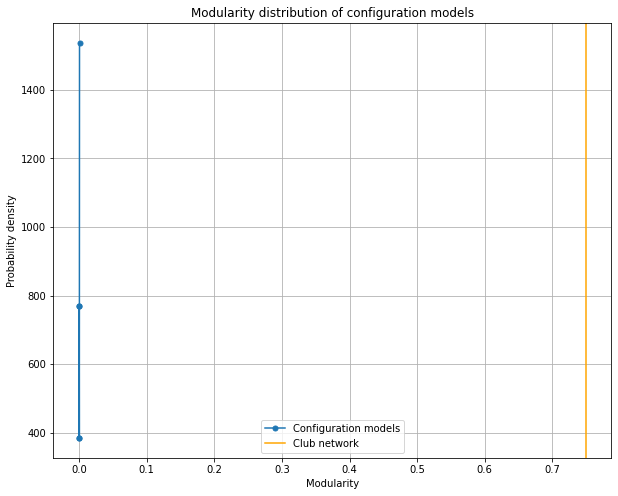

In [32]:
## Function for computing histograms
def in_out_degree_histogram(graph):

    in_degrees, out_degrees = graph_degrees(graph)
    bins = np.logspace(0, np.log10(max(in_degrees)), 10)
    in_hist, edges = np.histogram(in_degrees, bins=bins, density=True)
    x_in = (edges[1:] + edges[:-1]) / 2.

    bins = np.logspace(0, np.log10(max(out_degrees)), 10)
    out_hist, edges = np.histogram(out_degrees, bins=bins, density=True)
    x_out = (edges[1:] + edges[:-1]) / 2.
    
    return in_hist, x_in, out_hist, x_out


def bins(data, spacing=lambda x, b: np.linspace(0, max(x), b), bins=10):
    bins = spacing(data, bins+1)
    hist, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[1:] + edges[:-1]) / 2
    xx, yy = x[hist>0], hist[hist>0]
    return xx, yy
    
## Use binning function from Part 1
mod, dens = bins(random_modularities, lambda x, b: np.linspace(min(x), max(x), b), bins=5)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(mod, dens, marker=".", ms=10, label="Configuration models")
ax.axvline(modularity(graph=so_graph, partitions=partitions.values()), c="orange", label="Club network")
ax.grid(True)
ax.set_title("Modularity distribution of configuration models")
ax.set_xlabel("Modularity")
ax.set_ylabel("Probability density")
ax.legend()

## 6. Use the Louvain algorithm to create a network from the data and compare to the StackOverflow-network.


In [33]:
def modularity(graph: nx.Graph, *ns) -> float:
    """ ns are lists of nodes for each partition of the graph """
    nc = len(ns)
    s = 0
    for n in ns:
        subgraph = graph.subgraph(n)
        Lc = len(subgraph.edges)
        L = len(graph.edges)
        kc = sum(d for _, d in graph.degree(subgraph.nodes))
        s += Lc / L - (kc / (2 * L)) ** 2  # Eq. 9.12
    return s

partition = cm.best_partition(so_graph)
nc = max(partition.values()) + 1
ns = [[] for i in range(nc)]
for i, p in partition.items():
    ns[p].append(i)
print("Modularity according to Louvain algorithm: %.4f" % modularity(so_graph, *ns))
print("Number of partitions: %i" % nc)

TypeError: Bad graph type, use only non directed graph

# Extra..

In [ ]:
# ### Average shortest path for the largest connected component of the Stack Overflow network
# blocks = nx.algorithms.connected_components(so_graph)
# largest_block = set()
# m = 0
# # Compute largest connected component
# for b2lock in tqdm(blocks):
#     if len(block) < m:
#         continue
#     m = len(block)
#     largest_block = block

# # Get subgraph/giant component
# so_graph_sg = nx.Graph.subgraph(so_graph, largest_block)
# print("Number of nodes in largest connected component of the Stack Overflow network: %i" % len(so_graph_sg))

# ### Average shortest path length of the giant component
# avg_shortest_path = nx.average_shortest_path_length(so_graph_sg)
# print("Average shortest path: %.4f" % avg_shortest_path)

# ### The clustering coefficient for all nodes in the Stack Overflow Graph
# cluster_coefs = nx.algorithms.cluster.clustering(so_graph)
# avg_cluster_coef = sum(cluster_coefs.values()) / len(cluster_coefs)
# print("Average clustering coefficient in Stack Overflow network: %.6f" % avg_cluster_coef)